## Learning Rate Schedulers with Skorch 

This notebook demonstrates 3 learning rate schedulers in skorch:

StepLR, ReduceROn Plateau and Cosine Annealing

Firstly you will need to install the following libraries: skorch,numpy,matplotlib and torch.

<a href="" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"></a>


<a href="https://github.com/skorch-dev/skorch/blob/master/notebooks/Learning_Rate_Scheduler.ipynb" target="_blank"><img src="https://img.shields.io/github/view/yourusername/yourrepository/main/yourfile.ipynb" alt="View Source on GitHub"></a>


# Imports

In [47]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler

## Data Preparation

The dataset will be split into train and test datasets. We will scale the features upto float 32 and labels reshaped for efficient binary classification.


In [48]:
def prepare_data():
    data = load_breast_cancer()
    X, y = data.data, data.target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

    # Scaling data using a pipeline
    preprocessing_pipeline = Pipeline([('scaler', StandardScaler())])  
    X_train_scaled = preprocessing_pipeline.fit_transform(X_train).astype(np.float32)
    X_test_scaled = preprocessing_pipeline.transform(X_test).astype(np.float32)

    return X_train_scaled, X_test_scaled, y_train.astype(np.float32).reshape(-1, 1), y_test.astype(np.float32).reshape(-1, 1)

## Neural Net Parameters

The BreastCancerNet is a neural network designed for binary classification tasks. It consists of an input layer, two hidden layers with ReLU activation functions, and a single output layer with a Sigmoid activation function. The architecture is parameterized to allow flexibility in adjusting the input and hidden layer dimensions.

In [49]:
class BreastCancerNet(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

## Learning Rate Scheduler Parameters 

1) StepLR:

- Reduces the learning rate by a factor (gamma=0.3) every 100 epochs (step_size=10).
- Useful for steady, predictable learning rate decay.

2) ReduceLROnPlateau:

- Reduces the learning rate dynamically when the model's performance (e.g., loss) plateaus.
- Adjusts by a factor (factor=0.7) after 5 epochs of no improvement (patience=5).
- Ideal for tasks where loss stagnation indicates the need for smaller learning rates.

3) CosineAnnealing:

- Reduces the learning rate in a cosine curve over 10 epochs (T_max=10).
- Periodically resets the learning rate, promoting exploration of the loss landscape.


In [ ]:
def simulate_scheduler(scheduler_class, optimizer_params, steps, initial_lr, X_train, y_train, X_val, y_val, input_dim=30, hidden_dim=64):
    
    model = BreastCancerNet(input_dim=input_dim, hidden_dim=hidden_dim)
        
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    scheduler = scheduler_class(optimizer, **optimizer_params)

    
    criterion = nn.BCEWithLogitsLoss()

    
    lrs = []
    for step in range(steps):
        lrs.append(optimizer.param_groups[0]['lr'])
        
        
        model.train()
        optimizer.zero_grad()
        train_output = model(torch.tensor(X_train, dtype=torch.float32))
        loss = criterion(train_output, torch.tensor(y_train, dtype=torch.float32))
        loss.backward()
        optimizer.step()

 
        model.eval()
        with torch.no_grad():
            val_output = model(torch.tensor(X_val, dtype=torch.float32))
            val_loss = criterion(val_output, torch.tensor(y_val, dtype=torch.float32))
        
       
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)  
        else:
            scheduler.step()
    
    return np.array(lrs)


def train_schedulers(X_train, X_test, y_train, y_test, lr=0.05, epochs=1000, hidden_dim=128):
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
    
    
    schedulers = [
        {
            "name": "StepLR",
            "scheduler_class": torch.optim.lr_scheduler.StepLR,
            "params": {"step_size": 100, "gamma": 0.3},
        },
        {
            "name": "ReduceLROnPlateau",
            "scheduler_class": torch.optim.lr_scheduler.ReduceLROnPlateau,
            "params": {"mode": "max", "factor": 0.7, "patience": 5},
        },
        {
            "name": "CosineAnnealingLR",
            "scheduler_class": torch.optim.lr_scheduler.CosineAnnealingLR,
            "params": {"T_max": 1000},
        },
    ]

    results = {}
    for scheduler_info in schedulers:
       
        simulated_lrs = simulate_scheduler(
            scheduler_info["scheduler_class"],
            scheduler_info["params"],
            steps=epochs,
            initial_lr=lr,
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            input_dim=X_train.shape[1],
        )

        print(f"{scheduler_info['name']} Simulated LRs: {simulated_lrs[:5]}...")

        
        net = NeuralNetClassifier(
            module=BreastCancerNet,
            max_epochs=epochs,
            lr=lr,
            optimizer=optim.SGD,
            criterion=nn.BCEWithLogitsLoss(),
            callbacks=[LRScheduler(scheduler_info["scheduler_class"], **scheduler_info["params"])],
        )

       
        net.fit(X_train, y_train.reshape(-1, 1))
        score = net.score(X_test, y_test.reshape(-1, 1))

        
        results[scheduler_info["name"]] = {
            "model": net,
            "simulated_lrs": simulated_lrs,
            "score": score,
        }
        print(f"{scheduler_info['name']} Score: {score:.4f}")


    print("\nFinal Results Summary:")
    for scheduler_name, result in results.items():
        print(f"\nScheduler: {scheduler_name}")
        print(f"Score: {result['score']:.4f}")
        print(f"Simulated Learning Rates: {result['simulated_lrs'][:5]}...")  

    return results

In [3]:
def train_schedulers(X_train, X_test, y_train, y_test, lr=0.05, epochs=1000, hidden_dim=128):
    # Convert data to torch.float32
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

    schedulers = [
        {
            "name": "StepLR",
            "scheduler_class": torch.optim.lr_scheduler.StepLR,
            "params": {"step_size": 100, "gamma": 0.3},
        },
        {
            "name": "ReduceLROnPlateau",
            "scheduler_class": torch.optim.lr_scheduler.ReduceLROnPlateau,
            "params": {"mode": "max", "factor": 0.7, "patience": 5},
        },
        {
            "name": "CosineAnnealingLR",
            "scheduler_class": torch.optim.lr_scheduler.CosineAnnealingLR,
            "params": {"T_max": 1000},
        },
    ]

    results = {}
    for scheduler_info in schedulers:
        # Simulate learning rates
        simulated_lrs = simulate_scheduler(
            scheduler_info["scheduler_class"],
            scheduler_info["params"],
            steps=epochs,
            initial_lr=lr,
        )
        print(f"{scheduler_info['name']} Simulated LRs: {simulated_lrs[:5]}...")

        # Train the model with the scheduler
        net = NeuralNetClassifier(
            module=BreastCancerNet,
            max_epochs=epochs,
            lr=lr,
            optimizer=optim.SGD,
            criterion=nn.BCEWithLogitsLoss,
            callbacks=[
                LRScheduler(
                    policy=scheduler_info["scheduler_class"],
                    **scheduler_info["params"]
                )
            ],
            iterator_train__shuffle=True,
            train_split=None,  # Use external train-test split
            module__input_dim=X_train.shape[1],
            module__hidden_dim=hidden_dim,
        )

        net.fit(X_train.numpy(), y_train.numpy())  # Convert tensors to numpy
        score = net.score(X_test.numpy(), y_test.numpy())  # Convert tensors to numpy

        results[scheduler_info["name"]] = {
            "model": net,
            "simulated_lrs": simulated_lrs,
            "score": score,
        }
        print(f"{scheduler_info['name']} Score: {score:.4f}")

    print("\nFinal Results Summary:")
    for scheduler_name, result in results.items():
        print(f"\nScheduler: {scheduler_name}")
        print(f"Score: {result['score']:.4f}")
        print(f"Simulated Learning Rates: {result['simulated_lrs'][:5]}...")

    return results


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier
from skorch.callbacks import LRScheduler
from sklearn.model_selection import train_test_split

# Define the neural network model
class BreastCancerNet(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=64):
        super(BreastCancerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


def simulate_scheduler(scheduler_class, optimizer_params, steps, initial_lr):
    optimizer = torch.optim.SGD([torch.zeros(1, requires_grad=True)], lr=initial_lr)
    scheduler = scheduler_class(optimizer, **optimizer_params)
    lrs = []

    dummy_metric = 0.5 
    for _ in range(steps):
        lrs.append(optimizer.param_groups[0]['lr'])

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(dummy_metric)
        else:
            scheduler.step()

    return np.array(lrs)



def train_schedulers(X_train, X_test, y_train, y_test, lr=0.05, epochs=1000, hidden_dim=128):
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

    schedulers = [
        {"name": "StepLR", "scheduler_class": torch.optim.lr_scheduler.StepLR, "params": {"step_size": 100, "gamma": 0.3}},
        {"name": "ReduceLROnPlateau", "scheduler_class": torch.optim.lr_scheduler.ReduceLROnPlateau, "params": {"mode": "max", "factor": 0.7, "patience": 5}},
        {"name": "CosineAnnealingLR", "scheduler_class": torch.optim.lr_scheduler.CosineAnnealingLR, "params": {"T_max": 1000}},
    ]

    results = {}
    for scheduler_info in schedulers:
        simulated_lrs = simulate_scheduler(
            scheduler_info["scheduler_class"],
            scheduler_info["params"],
            steps=epochs,
            initial_lr=lr,
        )
        print(f"{scheduler_info['name']} Simulated LRs: {simulated_lrs[:5]}...")

        net = NeuralNetClassifier(
            module=BreastCancerNet,
            max_epochs=epochs,
            lr=lr,
            optimizer=optim.SGD,
            criterion=nn.BCEWithLogitsLoss,
            callbacks=[
                LRScheduler(
                    policy=scheduler_info["scheduler_class"],
                    **scheduler_info["params"]
                )
            ],
            iterator_train__shuffle=True,
            train_split=None,
            module__input_dim=X_train.shape[1],
            module__hidden_dim=hidden_dim,
        )

        net.fit(X_train.numpy(), y_train.numpy())
        score = net.score(X_test.numpy(), y_test.numpy())
        results[scheduler_info["name"]] = {
            "model": net,
            "simulated_lrs": simulated_lrs,
            "score": score,
        }
        print(f"{scheduler_info['name']} Score: {score:.4f}")

    print("\nFinal Results Summary:")
    for scheduler_name, result in results.items():
        print(f"\nScheduler: {scheduler_name}")
        print(f"Score: {result['score']:.4f}")
        print(f"Simulated Learning Rates: {result['simulated_lrs'][:5]}...")

    return results


# Direct execution (no if __name__ == "__main__")
X_train = np.random.rand(100, 30)
X_test = np.random.rand(40, 30)
y_train = np.random.randint(0, 2, size=(100,))
y_test = np.random.randint(0, 2, size=(40,))

results = train_schedulers(X_train, X_test, y_train, y_test, lr=0.05, epochs=1000, hidden_dim=128)


StepLR Simulated LRs: [0.05 0.05 0.05 0.05 0.05]...
  epoch    train_loss      lr     dur
-------  ------------  ------  ------
      1        0.6884  0.0500  0.0014
      2        0.6879  0.0500  0.0014
      3        0.6875  0.0500  0.0017
      4        0.6871  0.0500  0.0013
      5        0.6867  0.0500  0.0014
      6        0.6863  0.0500  0.0012
      7        0.6859  0.0500  0.0012
      8        0.6855  0.0500  0.0016
      9        0.6851  0.0500  0.0017
     10        0.6848  0.0500  0.0018
     11        0.6844  0.0500  0.0015
     12        0.6840  0.0500  0.0014
     13        0.6836  0.0500  0.0014
     14        0.6832  0.0500  0.0013
     15        0.6829  0.0500  0.0012
     16        0.6825  0.0500  0.0018
     17        0.6821  0.0500  0.0019
     18        0.6818  0.0500  0.0014
     19        0.6814  0.0500  0.0016
     20        0.6810  0.0500  0.0015
     21        0.6806  0.0500  0.0021
     22        0.6803  0.0500  0.0017
     23        0.6799  0.0500  0.001

/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


     72        0.6610  0.0500  0.0020
     73        0.6606  0.0500  0.0018
     74        0.6602  0.0500  0.0023
     75        0.6597  0.0500  0.0014
     76        0.6593  0.0500  0.0011
     77        0.6589  0.0500  0.0018
     78        0.6585  0.0500  0.0019
     79        0.6581  0.0500  0.0018
     80        0.6577  0.0500  0.0014
     81        0.6573  0.0500  0.0014
     82        0.6569  0.0500  0.0017
     83        0.6564  0.0500  0.0015
     84        0.6560  0.0500  0.0014
     85        0.6556  0.0500  0.0013
     86        0.6552  0.0500  0.0014
     87        0.6547  0.0500  0.0013
     88        0.6543  0.0500  0.0018
     89        0.6539  0.0500  0.0029
     90        0.6535  0.0500  0.0015
     91        0.6530  0.0500  0.0013
     92        0.6526  0.0500  0.0014
     93        0.6522  0.0500  0.0015
     94        0.6517  0.0500  0.0014
     95        0.6513  0.0500  0.0013
     96        0.6508  0.0500  0.0018
     97        0.6504  0.0500  0.0015
     98     

/home/codespace/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


     79        0.6652  0.0493  0.0021
     80        0.6648  0.0492  0.0016
     81        0.6644  0.0492  0.0015
     82        0.6640  0.0492  0.0016
     83        0.6636  0.0492  0.0013
     84        0.6632  0.0492  0.0018
     85        0.6627  0.0491  0.0012
     86        0.6623  0.0491  0.0017
     87        0.6619  0.0491  0.0014
     88        0.6615  0.0491  0.0018
     89        0.6611  0.0491  0.0012
     90        0.6606  0.0490  0.0016
     91        0.6602  0.0490  0.0016
     92        0.6598  0.0490  0.0015
     93        0.6594  0.0490  0.0013
     94        0.6589  0.0489  0.0019
     95        0.6585  0.0489  0.0010
     96        0.6581  0.0489  0.0017
     97        0.6577  0.0489  0.0013
     98        0.6572  0.0488  0.0020
     99        0.6568  0.0488  0.0018
    100        0.6564  0.0488  0.0017
    101        0.6559  0.0488  0.0018
    102        0.6555  0.0488  0.0024
    103        0.6551  0.0487  0.0014
    104        0.6547  0.0487  0.0011
    105     

# Training & Visualization of Results

We will now train the neural network with different LR Schedulers and plot a graph using matplotlib showing the difference between different learning rates.

We observe the following Results:

1) StepLR reduces the learning rate in fixed steps, ReduceLROnPlateau adaptively lowers it when progress stagnates, and CosineAnnealing follows a periodic decay to explore new minima. 

2) Choosing the right scheduler depends on task requirements, with StepLR suited for predefined decays, ReduceLROnPlateau for dynamic adjustments, and CosineAnnealing for periodic resets to escape local minima.

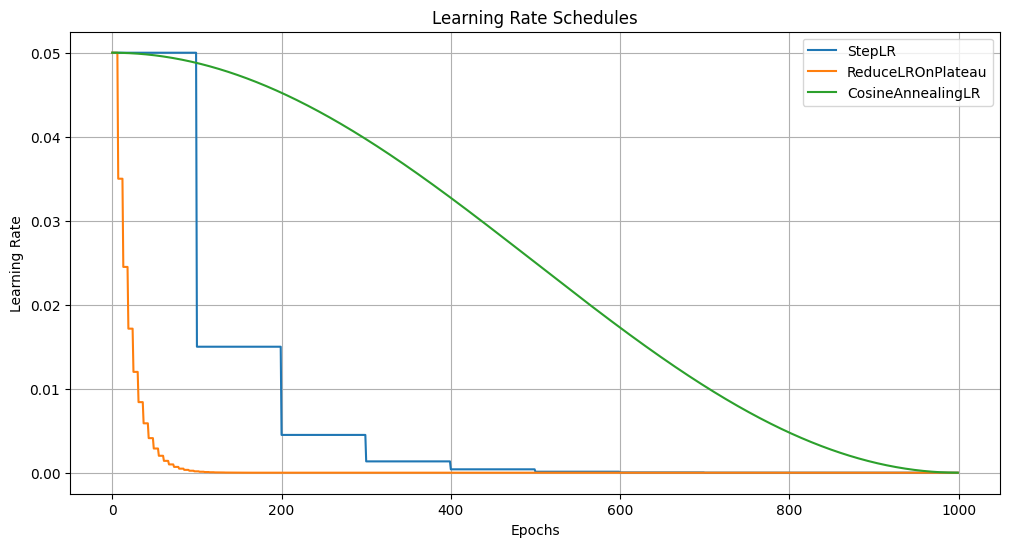

In [10]:
def plot_results(results, epochs):
    # Plot simulated learning rates
    plt.figure(figsize=(12, 6))
    for scheduler_name, result in results.items():
        plt.plot(result["simulated_lrs"], label=scheduler_name)
    plt.title("Learning Rate Schedules")
    plt.xlabel("Epochs")
    plt.ylabel("Learning Rate")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_results(results,epochs=100)